<a href="https://colab.research.google.com/github/Gitinitty-5/Python-Projects/blob/main/Udemy_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://www.kaggle.com/datasets/samtyagi/audacity-ab-testing/data

In this case study, you’ll analyze A/B test results for Audacity. Here's the customer funnel for typical new users on their site:


Audacity loses users as they go down the stages of this funnel, with only a few making it to the end. To increase student engagement, Audacity is performing A/B tests to try out changes that will hopefully increase conversion rates from one stage to the next.

We’ll analyze test results for two changes they have in mind, and then make a recommendation on whether they should launch each change.

The first change Audacity wants to try is on their homepage. They hope that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

The metric we will use is the click through rate for the Explore Courses button on the home page. Click through rate (CTR) is often defined as the the number of clicks divided by the number of views. Since Audacity uses cookies, we can identify unique users and make sure we don't count the same one multiple times. For this experiment, we'll define our click through rate as:

CTR: # clicks by unique users / # views by unique users

Now that we have our metric, let's set up our null and alternative hypotheses:

H0: CTR{new} \leq CTR _{old} H 0 ​ :CTR new ​ ≤CTR old ​

H1: CTR{new} > CTR _{old} H 1 ​ :CTR new ​ >CTR old ​

Our alternative hypothesis is what we want to prove to be true, in this case, that the new homepage design has a higher click through rate than the old homepage design. And the null hypothesis is what we assume to be true before analyzing data, which is that the new homepage design has a click through rate that is less than or equal to that of the old homepage design. As you’ve seen before, we can rearrange our hypotheses to look like this:

H0: CTR{new} - CTR_{old} \leq 0 H 0 ​ :CTR new ​ −CTR old ​ ≤0 H1: CTR{new} - CTR_{old} > 0 H 1 ​ :CTR new ​ −CTR old ​ >0

##1.1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import random

In [3]:
##Load Data
from google.colab import files
uploaded = files.upload()

Saving udemy_ab_testing.xlsx to udemy_ab_testing.xlsx


In [4]:
#observe the data
df = pd.read_excel("udemy_ab_testing.xlsx")
df

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
...,...,...,...,...
8183,2017-01-18 09:11:41.984113,192060,experiment,view
8184,2017-01-18 09:42:12.844575,755912,experiment,view
8185,2017-01-18 10:01:09.026482,458115,experiment,view
8186,2017-01-18 10:08:51.588469,505451,control,view


In [5]:
##find the information from the table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


In [6]:
##check for nulls
df.isnull().sum()

,0
timestamp,0
id,0
group,0
action,0


In [7]:
import pandas as pd

# Convert 'timestamp' column to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

#Convert a new column with (0) for views and (1) for clicks
df['converted_int']=df['action'].apply(lambda x: 1 if x=='click' else 0)
df['time_of_day'] = df['timestamp'].apply(lambda ts: 'morning' if (ts.hour > 6) and (ts.hour < 10)
                                           else 'midday' if (ts.hour >= 10) and (ts.hour < 16)
                                           else 'evening' if (ts.hour >= 16) and (ts.hour < 23)
                                           else 'midnight')
df

,timestamp,id,group,action,converted_int,time_of_day
0,2016-09-24 17:42:27.839496,804196,experiment,view,0,evening
1,2016-09-24 19:19:03.542569,434745,experiment,view,0,evening
2,2016-09-24 19:36:00.944135,507599,experiment,view,0,evening
3,2016-09-24 19:59:02.646620,671993,control,view,0,evening
4,2016-09-24 20:26:14.466886,536734,experiment,view,0,evening
...,...,...,...,...,...,...
8183,2017-01-18 09:11:41.984113,192060,experiment,view,0,morning
8184,2017-01-18 09:42:12.844575,755912,experiment,view,0,morning
8185,2017-01-18 10:01:09.026482,458115,experiment,view,0,midday
8186,2017-01-18 10:08:51.588469,505451,control,view,0,midday


In [8]:
###check for duration of the period
import pandas as pd

# Assuming df is your DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert 'timestamp' column to datetime objects

number_of_days= df['timestamp'].max()- df['timestamp'].min()
number_of_days

Timedelta('115 days 16:41:40.789831')

In [9]:
##group distribution
group_distribution = df.group.value_counts()

# Convert the Series to a DataFrame and reset the index
group_distribution_df = pd.DataFrame(group_distribution).reset_index()

# Rename the columns
group_distribution_df.columns = ['group', 'values']
group_distribution_df

,group,values
0,control,4264
1,experiment,3924


<ipython-input-10-305b1d20512c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= group_distribution_df, x= 'group', y= 'values', palette= ('red', 'blue'))


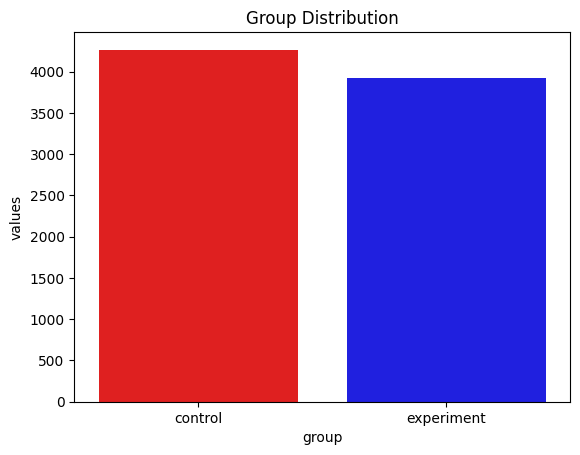

In [10]:
##plot a graph of the group distribution
sns.barplot(data= group_distribution_df, x= 'group', y= 'values', palette= ('red', 'blue'))
plt.title('Group Distribution')
plt.show()

In [11]:
# Count of total conversions (1s) for both groups
conversion_counts = df.groupby('group')['converted_int'].apply(lambda x: (x==1).sum())  # Count of '1s'
conversion_counts= pd.DataFrame({'group': conversion_counts.index, 'values': conversion_counts.values})
conversion_counts

,group,values
0,control,932
1,experiment,928


In [12]:
# Count of total non-conversions (0s) for both groups
non_conversion_counts = df.groupby('group')['converted_int'].apply(lambda x: (x == 0).sum())  # Count of '0s'
non_conversion_counts= pd.DataFrame({'group': non_conversion_counts.index, 'values': non_conversion_counts.values})
non_conversion_counts

,group,values
0,control,3332
1,experiment,2996


#Clickthrough Rate for Expirement Group

In [35]:
# Assuming your DataFrame is called 'df'

# Filter the DataFrame for the experiment group
# experiment group users
experiment_group = df.query("group == 'experiment'")


# click through rate for experiment group users
clickthrough_rate_exp = experiment_group.query("action == 'click'").nunique()['id']/experiment_group.query("action == 'view'").nunique()['id']
print(float(clickthrough_rate_exp))

0.3097463284379172


#Clickthrough Rate for Control Group


In [36]:
# control group users
control_group = df.query("group == 'control'")

# click through rate for experiment group users
clickthrough_rate_ctrl = control_group.query("action == 'click'").nunique()['id']/control_group.query("action == 'view'").nunique()['id']
print(float(clickthrough_rate_ctrl))

0.2797118847539016



Conversion Rates by Time of Day:
time_of_day
morning     0.219885
midnight    0.228109
midday      0.228230
evening     0.228363
Name: converted_int, dtype: float64


<ipython-input-15-cd16c4ed13ab>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= conversion_time_of_day.index, y= conversion_time_of_day.values, palette=('red', 'blue', 'yellow', 'green'))
<ipython-input-15-cd16c4ed13ab>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


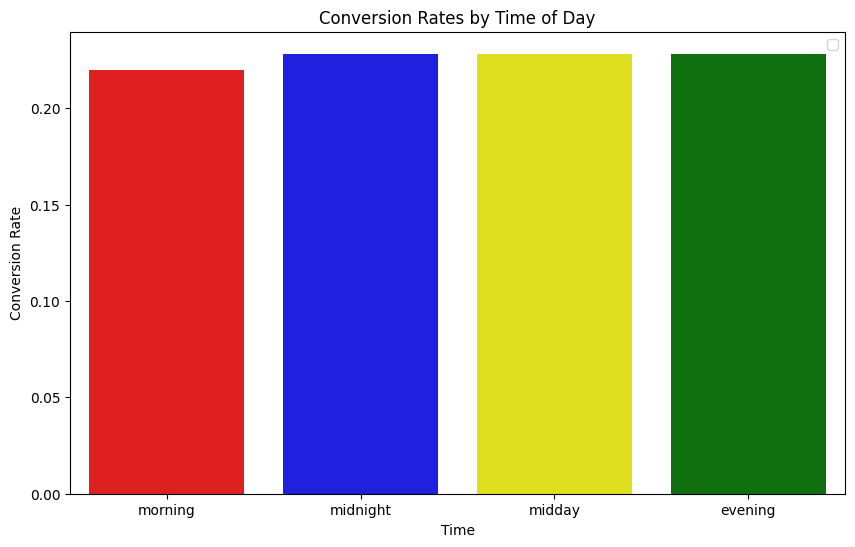

<ipython-input-15-cd16c4ed13ab>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= conversion_time_of_day.index, y= conversion_time_of_day.values, palette=('red', 'blue', 'yellow', 'green'))
<ipython-input-15-cd16c4ed13ab>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


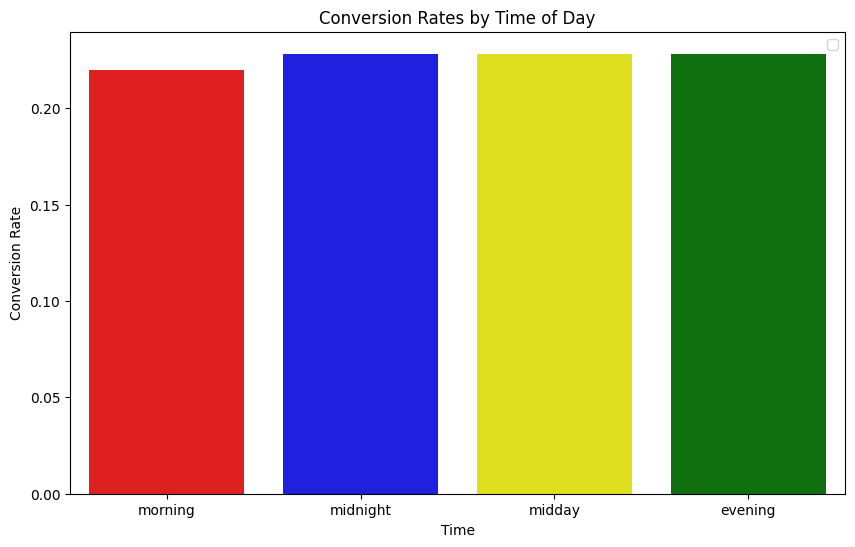

In [15]:
#conversion rates by day
conversion_time_of_day = df.groupby('time_of_day')['converted_int'].mean().reindex(
    ['morning', 'midday', 'evening', 'midnight']).sort_index(ascending=False) # Use sort_index instead of sortindex
print("\nConversion Rates by Time of Day:")
print(conversion_time_of_day)

plt.figure(figsize=(10, 6))
sns.barplot(x= conversion_time_of_day.index, y= conversion_time_of_day.values, palette=('red', 'blue', 'yellow', 'green'))
plt.legend()
plt.title('Conversion Rates by Time of Day')
plt.xlabel('Time')
plt.ylabel('Conversion Rate')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x= conversion_time_of_day.index, y= conversion_time_of_day.values, palette=('red', 'blue', 'yellow', 'green'))
plt.legend()
plt.title('Conversion Rates by Time of Day')
plt.xlabel('Time')
plt.ylabel('Conversion Rate')
plt.show()


Conversion Rates by Hour:
timestamp
0     0.233974
1     0.225225
2     0.234286
3     0.209913
4     0.215805
5     0.271429
6     0.215470
7     0.229692
8     0.196532
9     0.233236
10    0.223796
11    0.188060
12    0.233146
13    0.230337
14    0.250720
15    0.241983
16    0.205128
17    0.245946
18    0.255747
19    0.213115
20    0.220630
21    0.217791
22    0.234568
23    0.218289
Name: converted_int, dtype: float64


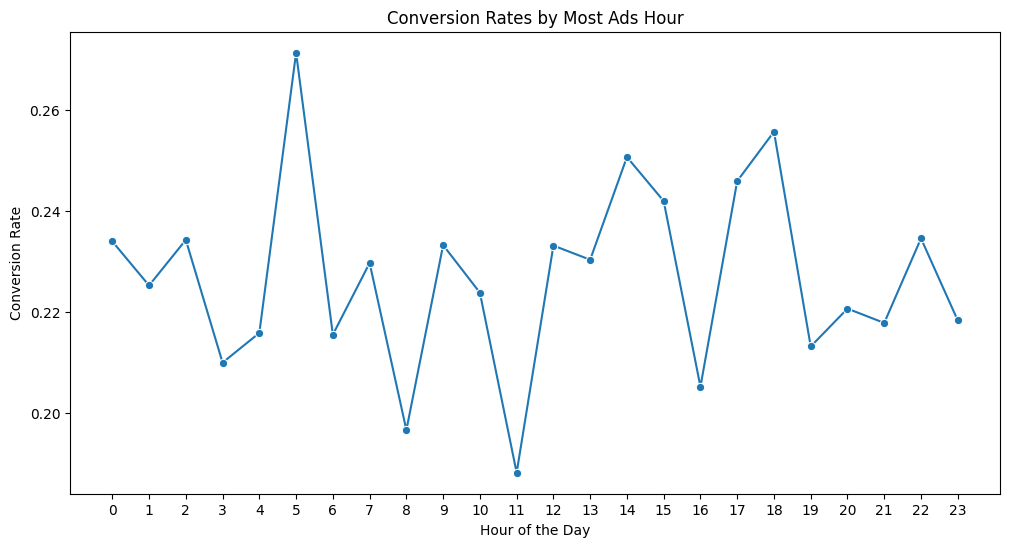

In [17]:
import pandas as pd

# Assuming df is your DataFrame
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Convert 'timestamp' column to datetime objects

##conversion by hour
conversion_by_hour = df.groupby(df['timestamp'].dt.hour)['converted_int'].mean() # Access the hour from the 'timestamp' column using .dt.hour
print("\nConversion Rates by Hour:")
print(conversion_by_hour)

plt.figure(figsize=(12, 6))
sns.lineplot(x=conversion_by_hour.index, y=conversion_by_hour.values, marker = 'o')
plt.title('Conversion Rates by Most Ads Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Rate')
plt.xticks(range(0, 24))
plt.show()

#A/B TESTING

Test 1

*Null Hypothesis (H0): There is no significant difference in conversion rates between (Expiriment) and ('Control') group.

*Alternative Hypothesis (H1): There is a significant difference in conversion rates between (Expirement) and (Control).




In [34]:
##Calculating for the sample sizes and conversion of various groups
conversion_counts = df.groupby('group')['converted_int'].sum()
sample_sizes = df['group'].value_counts()

# Calculate conversion rates
conversion_rates = conversion_counts / sample_sizes

print(f"Conversion Rates:{conversion_rates}")

print('*'*50)

print(f"\nConversion Counts:{conversion_counts}")

print('*'*50)

print(f"\nSample Sizes: {sample_sizes}")

Conversion Rates:group
control       0.218574
experiment    0.236493
dtype: float64
**************************************************

Conversion Counts:group
control       932
experiment    928
Name: converted_int, dtype: int64
**************************************************

Sample Sizes: group
control       4264
experiment    3924
Name: count, dtype: int64


Two Sample Test

In [33]:
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest


# Get conversion counts as a list or array
conversion_counts = df.groupby('group')['converted_int'].sum().values

# Perform one-sample t-test
total_users = df['group'].value_counts()
z_stat, p_val = proportions_ztest(count = conversion_counts, nobs = total_users)

print(f"z-Statistic: {z_stat}")

print('*'*120)
print(f"P-Value: {p_val}")

print('*'*120)

# Decision based on p-value
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is no significant difference in conversion rates between (Expiriment) and ('Control') group.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates between (Expirement) and (Control).")

z-Statistic: -1.9332699751308076
************************************************************************************************************************
P-Value: 0.05320294852289522
************************************************************************************************************************
Fail to reject the null hypothesis: No significant difference in conversion rates between (Expirement) and (Control).


Chi Square Test

In [32]:
from scipy.stats import chi2_contingency

# Use 'converted_int' instead of 'conversion_counts'
contingency_table = pd.crosstab(df['group'], df['converted_int'])

chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

# Decision based on p-value
alpha = 0.05
if p < alpha:  # Use p directly from chi2_contingency
    print("Reject the null hypothesis: There is a significant difference in conversion rates between the experiment and control groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference in conversion rates between the experiment and control groups.")

Chi-square statistic: 3.636160051233291
P-value: 0.056537191086915774
Fail to reject the null hypothesis: No significant difference in conversion rates between the experiment and control groups.


In conclusion, observing the various calculations of the clickthrough rates, two
sample test & Chi sqaure test, one could clearly indicate that we accept the Null Hypothesis due to the fact that, there is no significant difference between our Control & Expiremental Group.